In [64]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


In [31]:
data = pd.read_csv('../data/raw_analyst_ratings.csv')

# data = pd.read_csv('../data/raw_analyst_ratings.csv', parse_dates=['date'])

In [32]:
# DECRPTIVE STATISTICS

# count the length of each headline
data['headline_length'] = data['headline'].apply(len)
print(data['headline_length'].describe())

# count the length of each summary
publisher_count = data['publisher'].value_counts()
print(publisher_count)


# MISSING DATA
null_date = data['date'].isnull().sum()
print(null_date)

# Convert publication date to datetime
data['date'] = pd.to_datetime(data['date'],format='ISO8601',errors='coerce',utc=True)

# Group by date and count the number of articles
daily_headlines = data.groupby(data['date'].dt.date).size()

print(daily_headlines)


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
Matthew Ely               1
Frank Ochoa               1
Jeremie Capron            1
Marvin Dumont             1
Igor Gonta                1
Name: count, Length: 1034, dtype: int64
0
date
2009-02-14      1
2009-04-27      2
2009-04-29      1
2009-05-22      1
2009-05-27      6
             ... 
2020-06-07     25
2020-06-08    765
2020-06-09    803
2020-06-10    807
2020-06-11    544
Length: 3955, dtype: int64


In [34]:
time_series_data = pd.DataFrame({'date': daily_headlines.index, 'Headlined count': daily_headlines.values})
time_series_data.set_index('date', inplace=True)
print(time_series_data)

            Headlined count
date                       
2009-02-14                1
2009-04-27                2
2009-04-29                1
2009-05-22                1
2009-05-27                6
...                     ...
2020-06-07               25
2020-06-08              765
2020-06-09              803
2020-06-10              807
2020-06-11              544

[3955 rows x 1 columns]


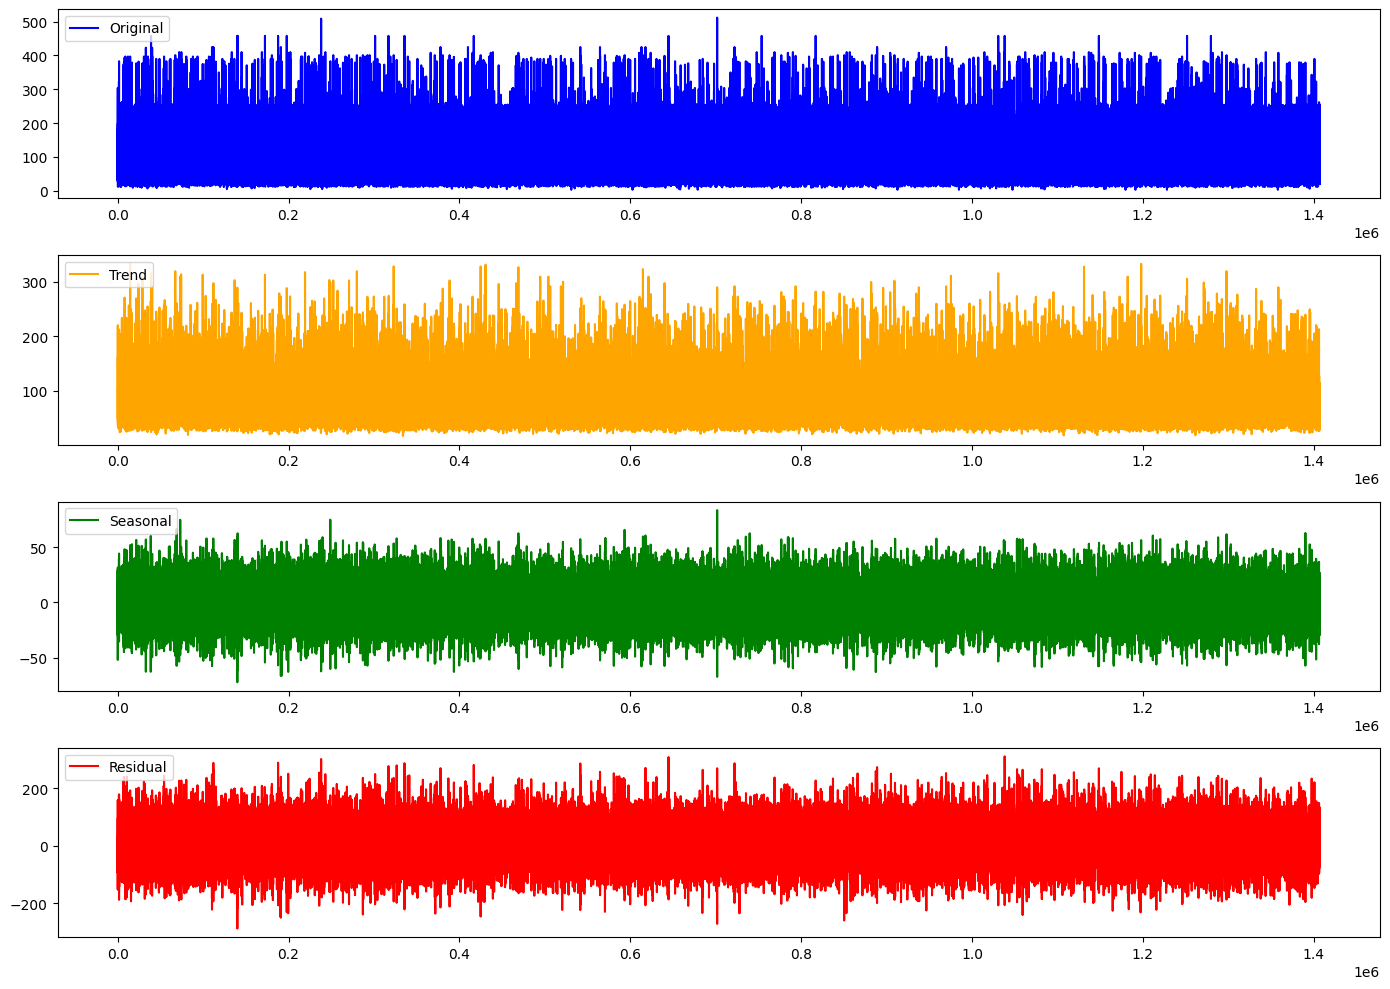

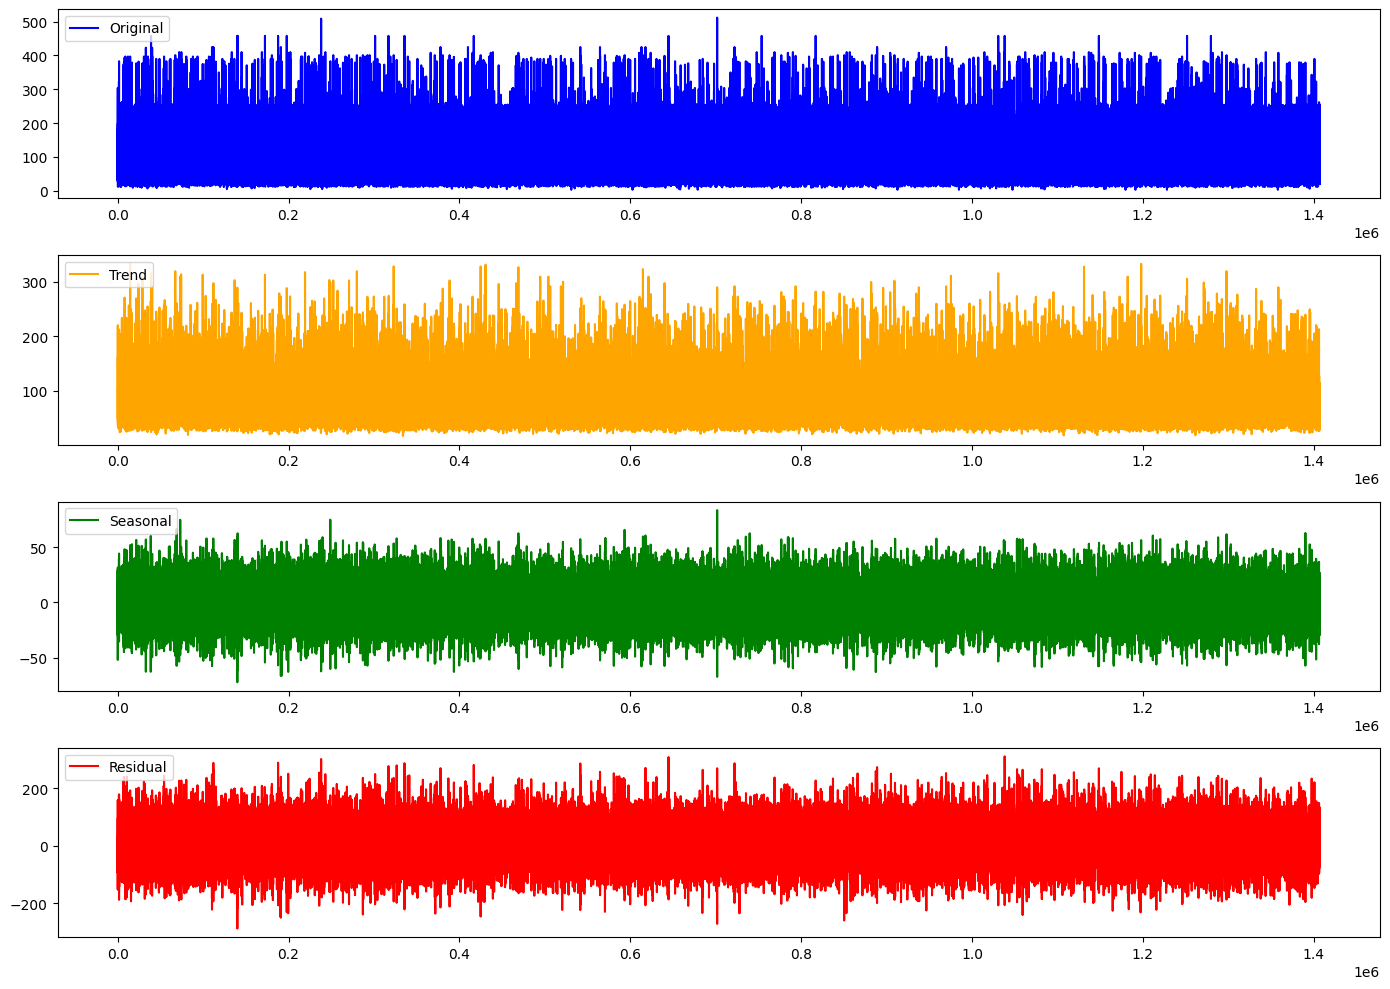

In [14]:


# Trend extraction
data['Trend'] = data['headline_length'].rolling(window=4, center=True).mean()


# Trend extraction
data['Trend'] = data['headline_length'].rolling(window=4, center=True).mean()

# Detrend to get seasonal + residual
detrended = data['headline_length'] - data['Trend']

# (Optional) Extract seasonality using a simple moving average of detrended data
data['Seasonal'] = detrended.rolling(window=4, center=True).mean()

# Residuals
data['Residual'] = detrended - data['Seasonal']

# Plotting the manually extracted components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(data['headline_length'], label='Original', color='blue')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(data['Trend'], label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(data['Seasonal'], label='Seasonal', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(data['Residual'], label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()




# Detrend to get seasonal + residual
detrended = data['headline_length'] - data['Trend']

# (Optional) Extract seasonality using a simple moving average of detrended data
data['Seasonal'] = detrended.rolling(window=4, center=True).mean()

# Residuals
data['Residual'] = detrended - data['Seasonal']

# Plotting the manually extracted components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(data['headline_length'], label='Original', color='blue')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(data['Trend'], label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(data['Seasonal'], label='Seasonal', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(data['Residual'], label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()





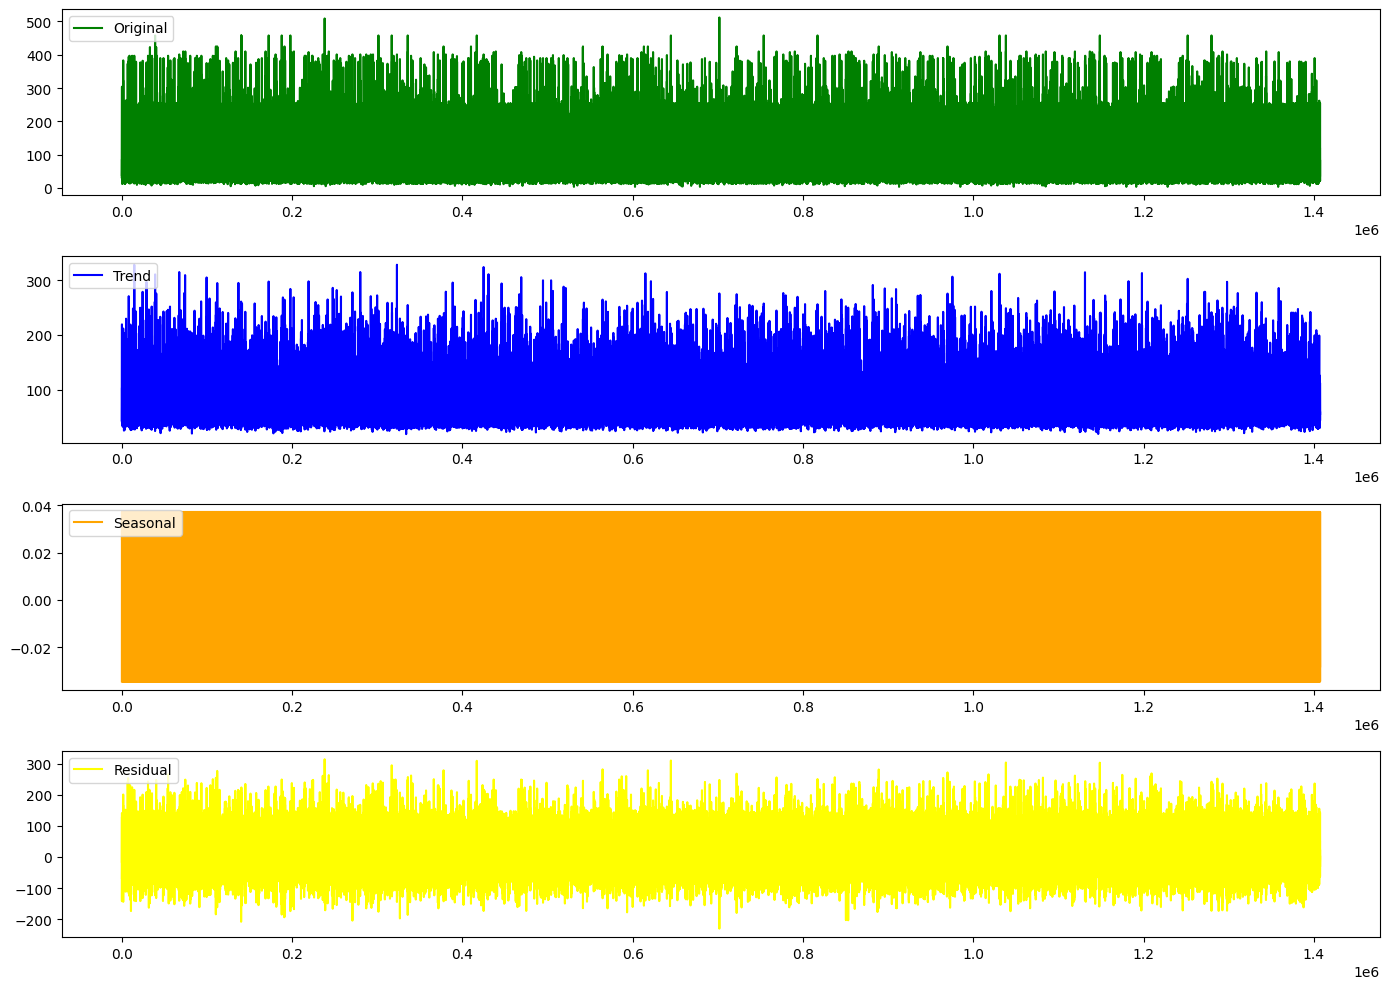

In [39]:
decomposition = seasonal_decompose(data['headline_length'], model='additive', period=4)

# Plot the original data, trend, seasonal and residuals
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(data['headline_length'], label='Original',color='green')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='orange')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='yellow')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

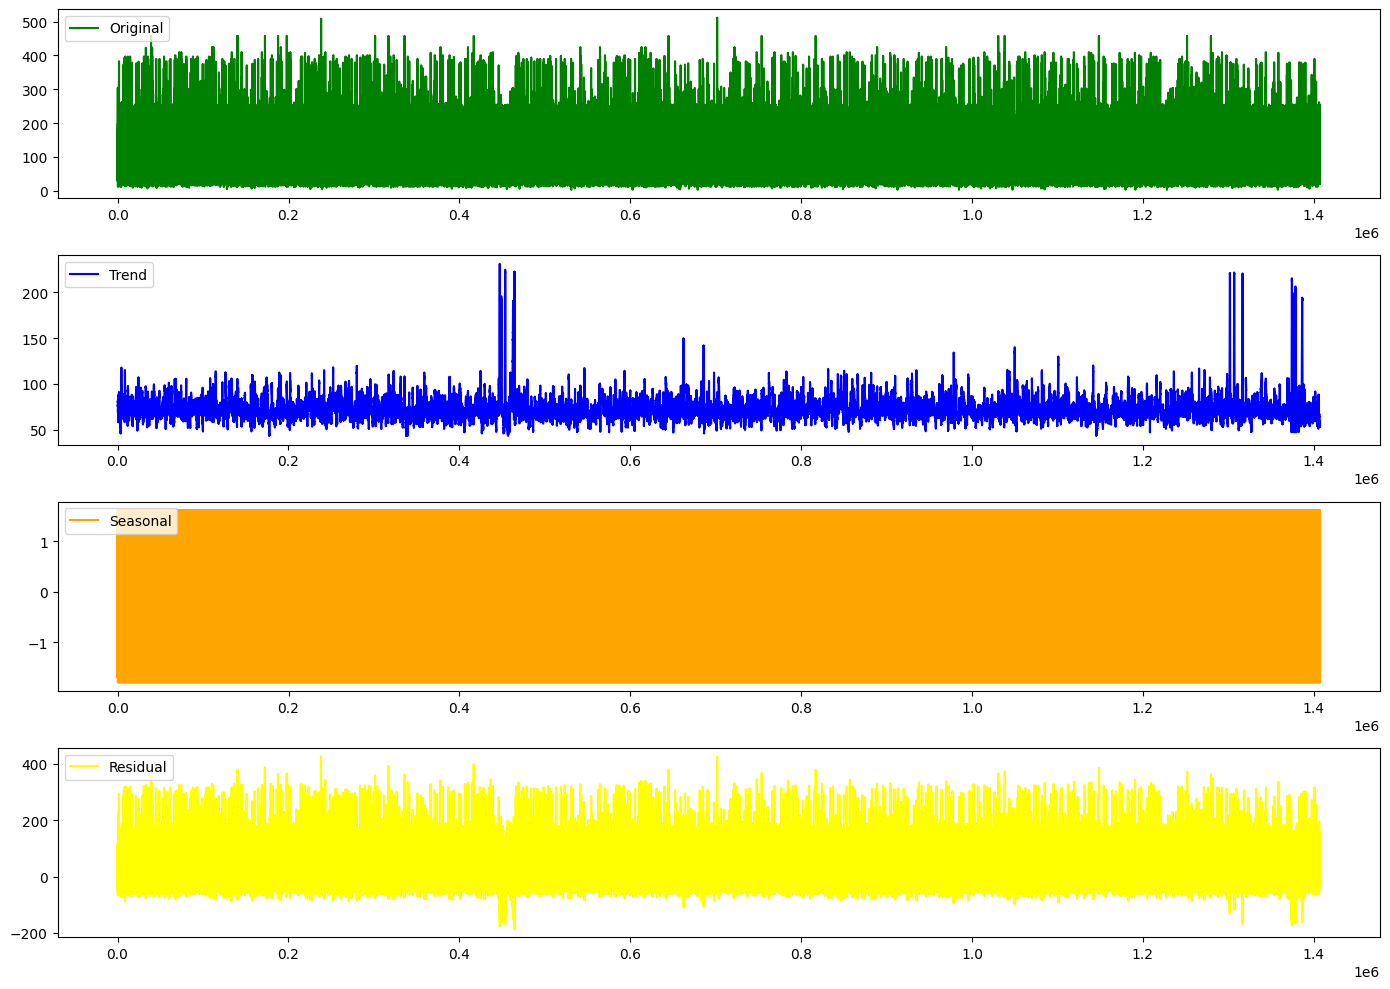

In [42]:
decomposition = seasonal_decompose(data['headline_length'], model='additive', period=365)

# Plot the original data, trend, seasonal and residuals
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(data['headline_length'], label='Original',color='green')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='orange')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='yellow')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [45]:
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    return polarity

def get_sentiment_catgory(text):
    sentiment = get_sentiment(text)
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'
    
data['sentiment'] = data['headline'].apply(get_sentiment)
data['sentiment_category'] = data['headline'].apply(get_sentiment_catgory)



In [47]:
data.tail()

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,sentiment,sentiment_category
1407323,1413844,Top Narrow Based Indexes For August 29,https://www.benzinga.com/news/11/08/1888782/to...,Monica Gerson,2011-08-29 04:00:00+00:00,ZX,38,0.15,positive
1407324,1413845,Recap: Wednesday's Top Percentage Gainers and ...,https://www.benzinga.com/news/earnings/11/06/1...,Benjamin Lee,2011-06-22 04:00:00+00:00,ZX,52,0.15,positive
1407325,1413846,UPDATE: Oppenheimer Color on China Zenix Auto ...,https://www.benzinga.com/analyst-ratings/analy...,BenzingaStaffL,2011-06-21 04:00:00+00:00,ZX,56,0.00,neutral
1407326,1413847,Oppenheimer Initiates China Zenix At Outperfor...,https://www.benzinga.com/analyst-ratings/price...,Joe Young,2011-06-21 04:00:00+00:00,ZX,54,0.00,neutral
1407327,1413848,China Zenix Auto International Opens For Tradi...,https://www.benzinga.com/news/ipos/11/05/10789...,Allie Wickman,2011-05-12 04:00:00+00:00,ZX,81,0.00,neutral


In [65]:
# Keyword Extraction
data = data.head(100)

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['headline'])
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
keyword_counts = df.sum(axis=0).sort_values(ascending=False)
print("Most common keywords:")
print(keyword_counts.head(10))

# Phrase Extraction
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(data['headline'])
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
phrase_counts = df.sum(axis=0).sort_values(ascending=False)
print("\nMost common phrases:")
print(phrase_counts.head(10))

# Topic Modeling
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['headline'])
lda = LatentDirichletAllocation(n_components=2, random_state=0)
lda.fit(X)
feature_names = vectorizer.get_feature_names_out()
print("\nExtracted topics:")
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[-10:]]))

Most common keywords:
agilent         43
technologies    27
stocks          25
shares          24
trading         23
price           20
target          19
week            19
companies       17
hit             16
dtype: int64

Most common phrases:
agilent technologies    27
price target            19
52 week                 16
stocks hit              16
hit 52                  16
companies trading       15
week highs              14
trading higher          13
healthcare companies    12
shares healthcare       12
dtype: int64

Extracted topics:
Topic 0:
moving session 2020 thursday friday highs week hit 52 stocks
Topic 1:
higher companies neutral trading shares maintains target price technologies agilent
